# Suppressing instability on a Vlasov-Poisson system with an external electric field
## Example: Bump on tail distribution

$$\mu(v) = \frac{9}{10\sqrt{2\pi}} \exp\left(-\frac{(v - \bar{v}_1)^2}{2}\right)
        + \frac{\sqrt{2}}{10\sqrt{\pi}} \exp\left(-2(v - \bar{v}_2)^2\right).$$

$$f(0, x, v) = \frac{\sqrt{2}\,\varepsilon}{10\sqrt{\pi}} \exp\left(-2(v - \bar{v}_2)^2\right)\cos(\beta x) + \mu(v).$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import jax
Array = jax.Array
import jax.numpy as jnp
import jax.scipy as jsp
from jax.scipy import optimize
import scipy.stats
import dataclasses
from functools import partial
from typing import Callable, Union

import optax

from VP_solver.jax_vp_solver import Mesh, make_mesh, VlasovPoissonSolver
from Utils.utils import plot_feq_distribution, plot_distribution

matplotlib.rcParams.update({
    'font.size': 14,  # General font size
    'axes.labelsize': 14,  # Axis label size
    'axes.titlesize': 14,  # Title size
    'xtick.labelsize': 14,  # X-tick label size
    'ytick.labelsize': 14,  # Y-tick label size
    'legend.fontsize': 14   # Legend font size
})

print(jax.devices())

[CudaDevice(id=0)]


## Problem setup and forward solver setup

In [2]:
# Setup
nx = 256
nv = 256
dt = 0.1
t_final = 40  # Adjusted for demonstration purposes
L = 20 * jnp.pi
LV = 9.0

In [3]:
mesh = make_mesh(L, LV, nx, nv)


mu1 = -3
mu2 = 4.5
f_eq = (9 * jnp.exp(-0.5 * (mesh.V - mu1)**2))/(10*jnp.sqrt(2*jnp.pi))\
        + (jnp.sqrt(2) * jnp.exp(-2 * (mesh.V - mu2)**2))/(10*jnp.sqrt(jnp.pi))
epsilon1 = 0.001
epsilon2 = 0.001
k_0 = 0.1
f_iv = (epsilon1 * jnp.cos(k_0 * mesh.X) + epsilon2 * jnp.sin(k_0 * mesh.X)) \
        * (jnp.sqrt(2) * jnp.exp(-2 * (mesh.V - mu2)**2)) / (10*jnp.sqrt(jnp.pi)) + f_eq

In [4]:
# Function to compute the external field H (not time-dependent)
def compute_external_field(ak, mesh):
    k = jnp.arange(1, len(ak[0,:]) + 1)  # Create an array of k values from 1 to len(a_k)
    H = ak[0,:] @ jnp.cos(k[:, None] * k_0 * mesh.xs) \
            + ak[1,:] @ jnp.sin(k[:, None]* k_0 * mesh.xs)  # Vectorized computation
    return H

In [5]:
solver = VlasovPoissonSolver(mesh=mesh, dt=dt, f_eq=f_eq)

# JIT-compiled forward solver
solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))

In [6]:
# External field parameters (coefficients for the cosine terms)
k_total = 14
ak1 = jax.random.uniform(jax.random.key(888), (2,k_total), minval=-1.0, maxval=1.0)
#ak2 = jax.random.uniform(jax.random.key(0), (2,k_total), minval=-1.0, maxval=1.0)
#a_k = jnp.array([
#    3.5164488e-04, 9.0411077e-06, -3.1953386e-05, -6.0834586e-06,
#    5.8570990e-06, 6.0852408e-06, -2.7067827e-06, -8.1664248e-06,
#    -8.8577590e-06, -9.7180082e-06, -9.5229143e-06, -9.5641644e-06,
#    -8.8652696e-06, -8.6681093e-06, -7.7312543e-06])
#b_k = jnp.array([-9.6406386e-04,
#    -5.9252861e-04, 2.9924628e-05, 4.2226049e-05, 5.3339943e-05,
#    3.5979556e-05, 2.5546415e-05, 1.0124806e-05, 6.6790512e-06,
#    1.3618927e-06, 3.0158180e-06, 7.7909431e-07, 3.0062322e-06,
#    1.2950333e-06, 3.2279252e-06])

#ak = jnp.stack([a_k, b_k])

# Compute the external field
H1 = compute_external_field(ak1, mesh)
#H2 = compute_external_field(ak2, mesh)

# num_steps = int(t_final / dt)

In [7]:
f_array1, E_array1, ee_array1 = solver_jit(f_iv, 0.0*H1, t_final=t_final)

#f_array2, E_array2, ee_array2 = solver_jit(f_iv, 0.0*H2, t_final=t_final)

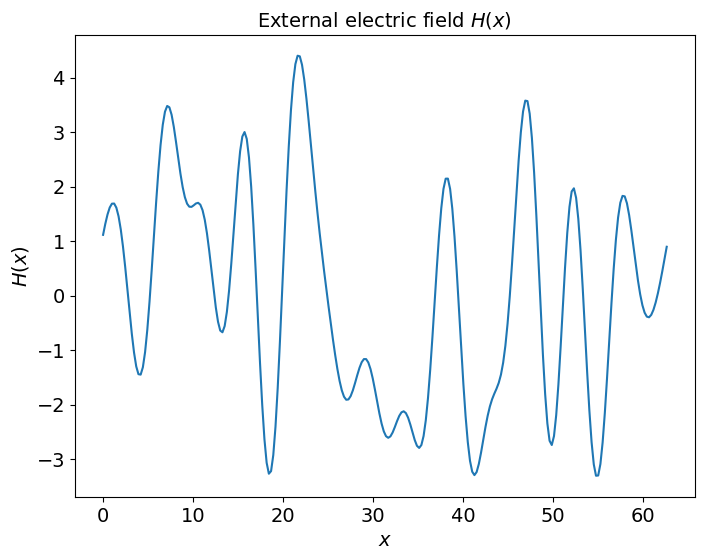

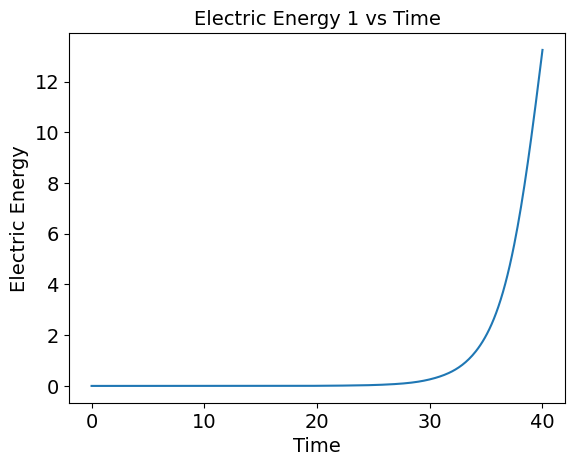

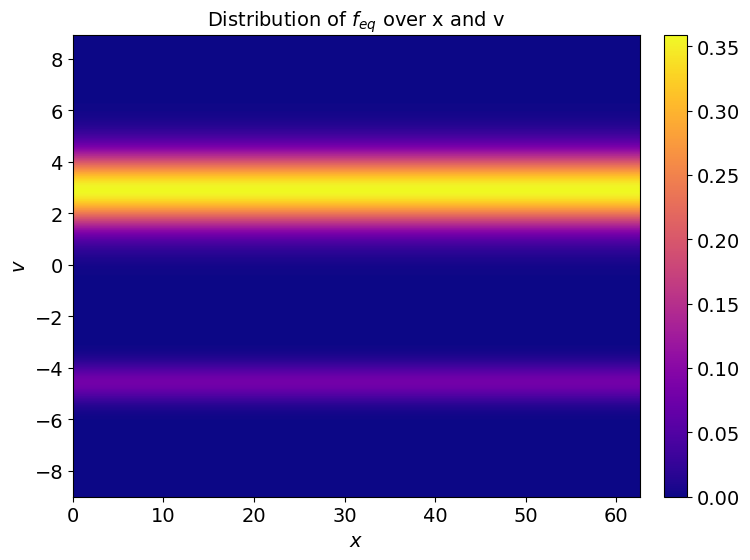

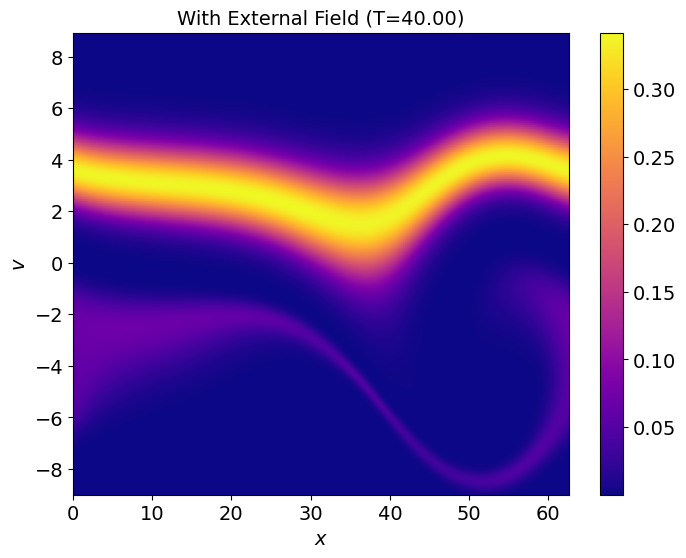

In [8]:
# Create a figure with a single plot for electric energy
fig, ax = plt.subplots(figsize=(8, 6))
t_values = jnp.linspace(0, t_final, int(t_final / dt))


#fig, axs = plt.subplots(2, 2)

plt.plot(mesh.xs, H1, label='Init 1')
#plt.plot(mesh.xs, H2, label='Init 2')
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('External electric field $H(x)$')
#plt.legend()
plt.show()

plt.plot(t_values, ee_array1, label='Init 1')
#plt.plot(t_values, ee_array2, label='Init 2')
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy 1 vs Time')
#plt.legend()
#plt.grid(True)
plt.show()
         
# Create a figure with a single plot for f_eq
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution of f_eq over x and v
plot_feq_distribution(fig, ax, f_eq, 'Distribution of $f_{eq}$ over x and v', mesh)

plt.show()

# Create a figure with a single plot
fig, ax = plt.subplots(1,1 ,figsize=(8, 6))

# f_array is already a 2D array, so pass it directly to the plot
plot_distribution(fig, ax, f_array1, 'With External Field', t_final, mesh)

#plot_distribution(fig, axs[1], f_array2, 'With External Field 2', t_final)
plt.show()

## Optimization: finding the coefficients of the external electric field to suppress instability

### $L^{2}$ objecive function

In [9]:
# Optimization through auto-differentiation with fixed basis.

# Adjust the J function to use f_final
def L2(f_final, solver):
    return jnp.sum((f_final - solver.f_eq) ** 2) * solver.mesh.dx * solver.mesh.dv

@jax.jit
def cost_function_L2(a_k):
    H = compute_external_field(a_k, mesh)
    # JIT-compiled forward solver
    #solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))
    f_array, E_array, ee_array = solver_jit(f_iv, H, t_final)
    #f_final = f_array
    cost = L2(f_array, solver)
    return cost

#### L-BFGS

In [10]:
maxiter = 2000
#solver_opt = jaxopt.LBFGS(fun=cost_function_L2, maxiter=maxiter)
solver_opt = optax.lbfgs()

# Define a scan function to iterate with `jax.lax.scan`
def scan_fn(carry, _):
#    x, state = carry
#    x, state = solver_opt.update(x, state)
#    obj_value = cost_function_L2(x)
#    return (x, state), obj_value
    params, opt_state = carry
    value, grad = value_and_grad(params, state=opt_state)
    updates, opt_state = solver_opt.update(
    grad, opt_state, params, value=value, grad=grad, value_fn=cost_function_L2)
    params = optax.apply_updates(params, updates)
    obj_value = cost_function_L2(params)
    return (params, opt_state), obj_value

In [ ]:
# Initial point and state
# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
ak_init_1 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-1.0, maxval=1.0)
#init_state = solver_opt.init_state(ak_init_1)
opt_state = solver_opt.init(ak_init_1)
value_and_grad = jax.jit(optax.value_and_grad_from_state(cost_function_L2))


# Run the optimization and collect objective values using `scan`
res_opt_l2_1, objective_values_l2_1 = jax.lax.scan(scan_fn, (ak_init_1, opt_state), None, length=maxiter)


ak_opt_l2_1, state = res_opt_l2_1

In [ ]:
#k_total = 14
#ak_init_1 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-1.0, maxval=1.0)

#ak_opt_l2_1 = jnp.load('Results_coeff/Bump-on-Tail/LB_L2_eps1={}_eps2={}.npy'.format(epsilon1,epsilon2))

In [ ]:
H_init_1 = compute_external_field(ak_init_1, mesh)
H_l2_1 = compute_external_field(ak_opt_l2_1, mesh)
ff_array1, E_array1, ee_array1 = solver.run_forward_jax_scan(f_iv, H_l2_1, t_final)

f_final1 = ff_array1

error_l2_1 = jnp.sum((f_final1 - f_eq)**2) * mesh.dx * mesh.dv

print("L^2 error= {}".format(error_l2_1))

jnp.save('Results_coeff/Bump-on-Tail/LB_L2_eps1={}_eps2={}.npy'.format(epsilon1,epsilon2), ak_opt_l2_1)

In [ ]:
plt.plot(mesh.xs, H_init_1, label='L-BFGS')
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('Initial external electric field $H(x)$')
plt.legend()
plt.show()

plt.plot(mesh.xs, H_l2_1, label='L-BFGS')
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('External electric field $H(x)$')
plt.legend()
plt.show()

# Plot the convergence
#objective_values_kl = jax.device_get(objective_values_kl)  # Move from device to host
plt.plot(objective_values_l2_1, label='L-BFGS')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("$L^{2}$")
plt.title("Convergence of Objective Function")
plt.legend()
plt.show()


plt.plot(t_values, ee_array1, label='L-BFGS')
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy vs Time')
plt.legend()
#plt.grid(True)
plt.show()

plt.plot(mesh.xs, E_array1[-1], label='L-BFGS')
plt.xlabel('$x$')
plt.ylabel('$E(x)$')
plt.title('Electric field $E(x)$ at time $T={}$'.format(t_final))
plt.legend()
#plt.grid(True)
plt.show()

# Create a figure for two subplots
fig, ax = plt.subplots(1,1 ,figsize=(8, 6))


plot_distribution(fig, ax, f_final1, 'With External Field (L-BFGS)', t_final, mesh)

plt.show()

fig, ax = plt.subplots(1,1 ,figsize=(8, 6))

plot_distribution(fig, ax, jnp.abs(f_final1 - f_eq), '$|f_{L-BFGS}(T) - f_{eq}|$', t_final, mesh)
plt.show()

#### Gradient Descent

In [ ]:
maxiter = 12000
learning_rate = 1e-9
solver_opt = optax.sgd(learning_rate=learning_rate)
#solver_opt = optax.chain(
#   optax.sgd(learning_rate=learning_rate),
#   optax.scale_by_zoom_linesearch(max_linesearch_steps=20)
#)
#grad_cost_function_L2 = jax.jit(jax.grad(cost_function_L2))

def scan_fn_gd(carry, _):
#    x, state = carry
#    x, state = solver_opt.update(x, state)
#    obj_value = cost_function_L2(x)
#    return (x, state), obj_value
    params, opt_state = carry
    grad_ = grad(params)
    updates, opt_state = solver_opt.update(grad_, opt_state, params)
    params = optax.apply_updates(params, updates)
#    params -= learning_rate*grad_cost_function_L2(params)
    obj_value = cost_function_L2(params)
    return (params, opt_state), obj_value

In [ ]:
# Initial point and state
# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
ak_init_2 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-0.01, maxval=0.01)
#init_state = solver_opt.init_state(ak_init_2)
opt_state = solver_opt.init(ak_init_2)
#value_and_grad = jax.jit(optax.value_and_grad_from_state(cost_function_L2))
grad = jax.jit(jax.grad(cost_function_L2))

# Run the optimization and collect objective values using `scan`
res_opt_l2_2, objective_values_l2_2 = jax.lax.scan(scan_fn_gd, (ak_init_2, opt_state), None, length=maxiter)


ak_opt_l2_2, state = res_opt_l2_2

In [ ]:
#k_total = 14
#ak_init_2 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-0.01, maxval=0.01)

#ak_opt_l2_2 = jnp.load('Results_coeff/Bump-on-Tail/GD_L2_eps1={}_eps2={}.npy'.format(epsilon1,epsilon2))

In [ ]:
H_init_2 = compute_external_field(ak_init_2, mesh)
H_l2_2 = compute_external_field(ak_opt_l2_2, mesh)
ff_array2, E_array2, ee_array2 = solver.run_forward_jax_scan(f_iv, H_l2_2, t_final)

f_final2 = ff_array2

error_l2_2 = jnp.sum((f_final2 - f_eq)**2) * mesh.dx * mesh.dv

print("L^2 error= {}".format(error_l2_2))

jnp.save('Results_coeff/Bump-on-Tail/GD_L2_eps1={}_eps2={}.npy'.format(epsilon1,epsilon2), ak_opt_l2_2)

In [ ]:
plt.plot(mesh.xs, H_init_2, label='GD')
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('Initial external electric field $H(x)$')
#plt.legend()
plt.show()

plt.plot(mesh.xs, H_l2_2, label='GD')
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('External electric field $H(x)$')
plt.legend()
plt.show()

# Plot the convergence
plt.plot(objective_values_l2_2, label='GD')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("$L^2$")
plt.title("Convergence of Objective Function")
plt.legend()
plt.show()


plt.plot(t_values, ee_array2, label='GD')
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy vs Time')
plt.legend()
#plt.grid(True)
plt.show()

plt.plot(mesh.xs, E_array2[-1], label='GD')
plt.xlabel('$x$')
plt.ylabel('$E(x)$')
plt.title('Electric field $E(x)$ at time $T={}$'.format(t_final))
plt.legend()
#plt.grid(True)
plt.show()

# Create a figure for two subplots
fig, ax = plt.subplots(1,1 ,figsize=(8, 6))


plot_distribution(fig, ax, f_final2, 'With External Field (GD)', t_final, mesh)
plt.show()

fig, ax = plt.subplots(1,1 ,figsize=(8, 6))

plot_distribution(fig, ax, jnp.abs(f_final2 - f_eq), '$|f_{GD}(T) - f_{eq}|$', t_final, mesh)
plt.show()

### $KL$ objective function

In [ ]:
# Optimization through auto-differentiation with fixed basis.

def kl_divergence(f_final, solver, eps=1e-8):
    # Normalize the distributions so they sum to 1
    f_final = f_final / (jnp.sum(f_final) * solver.mesh.dx * solver.mesh.dv + eps)
    f_eq = solver.f_eq / (jnp.sum(solver.f_eq) * solver.mesh.dx * solver.mesh.dv + eps)
    
    # Compute KL divergence, adding eps to avoid log(0)
    kl_div = jnp.sum(jax.scipy.special.rel_entr(f_final, f_eq + eps) * solver.mesh.dx * solver.mesh.dv)
    #kl_div = jnp.sum(f_final * jnp.log(f_final / (f_eq + eps) + eps)) * solver.mesh.dx * solver.mesh.dv
    return kl_div

@jax.jit
def cost_function_kl(a_k):
    H = compute_external_field(a_k, mesh)
    # JIT-compiled forward solver
    #solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))
    f_array, E_array, ee_array = solver_jit(f_iv, H, t_final)
    #f_final = f_array
    cost = kl_divergence(f_array, solver)
    return cost

#### L-BFGS

In [ ]:
maxiter = 2000
solver_opt = optax.lbfgs()
#solver_opt = jaxopt.LBFGS(fun=cost_function_kl, maxiter=maxiter)

# Define a scan function to iterate with `jax.lax.scan`
def scan_fn(carry, _):
    #x, state = carry
    #x, state = solver_opt.update(x, state)
    #obj_value = cost_function_kl(x)
    #return (x, state), obj_value
    params, opt_state = carry
    value, grad = value_and_grad(params, state=opt_state)
    updates, opt_state = solver_opt.update(
    grad, opt_state, params, value=value, grad=grad, value_fn=cost_function_L2)
    params = optax.apply_updates(params, updates)
    obj_value = cost_function_L2(params)
    return (params, opt_state), obj_value

In [ ]:
# Initial point and state
# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
ak_init_1 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-1.0, maxval=1.0)
#init_state = solver_opt.init_state(ak_init_1)
opt_state = solver_opt.init(ak_init_1)
value_and_grad = jax.jit(optax.value_and_grad_from_state(cost_function_kl))


# Run the optimization and collect objective values using `scan`
res_opt_kl_1, objective_values_kl_1 = jax.lax.scan(scan_fn, (ak_init_1, opt_state), None, length=maxiter)


ak_opt_kl_1, state = res_opt_kl_1

In [ ]:
H_init_1 = compute_external_field(ak_init_1, mesh)
H_kl_1 = compute_external_field(ak_opt_kl_1, mesh)
ff_array1, E_array1, ee_array1 = solver.run_forward_jax_scan(f_iv, H_kl_1, t_final)

f_final1 = ff_array1

error_kl_1 = jnp.sum((f_final1 - f_eq)**2) * mesh.dx * mesh.dv

print("L^2 error= {}".format(error_kl_1))

jnp.save('Results_coeff/Bump-on-Tail/LB_KL_eps1={}_eps2={}.npy'.format(epsilon1,epsilon2), ak_opt_kl_1)

In [ ]:
plt.plot(mesh.xs, H_init_1, label='L-BFGS')
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('Initial external electric field $H(x)$')
plt.legend()
plt.show()

plt.plot(mesh.xs, H_kl_1, label='L-BFGS')
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('External electric field $H(x)$')
plt.legend()
plt.show()

# Plot the convergence
#objective_values_kl = jax.device_get(objective_values_kl)  # Move from device to host
plt.plot(objective_values_kl_1, label='L-BFGS')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("KL")
plt.title("Convergence of Objective Function")
plt.legend()
plt.show()


plt.plot(t_values, ee_array1, label='L-BFGS')
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy vs Time')
plt.legend()
#plt.grid(True)
plt.show()

plt.plot(mesh.xs, E_array1[-1], label='L-BFGS')
plt.xlabel('$x$')
plt.ylabel('$E(x)$')
plt.title('Electric field $E(x)$ at time $T={}$'.format(t_final))
plt.legend()
#plt.grid(True)
plt.show()

# Create a figure for two subplots
fig, ax = plt.subplots(1,1 ,figsize=(8, 6))


plot_distribution(fig, ax, f_final1, 'With External Field (L-BFGS)', t_final, mesh)

plt.show()

fig, ax = plt.subplots(1,1 ,figsize=(8, 6))

plot_distribution(fig, ax, jnp.abs(f_final1 - f_eq), '$|f_{L-BFGS}(T) - f_{eq}|$', t_final, mesh)
plt.show()

#### Gradient Descent

In [ ]:
maxiter = 12000
learning_rate = 1e-9
solver_opt = optax.sgd(learning_rate=learning_rate)
#solver_opt = optax.chain(
#   optax.sgd(learning_rate=learning_rate),
#   optax.scale_by_zoom_linesearch(max_linesearch_steps=20)
#)
#grad_cost_function_L2 = jax.jit(jax.grad(cost_function_L2))

def scan_fn_gd(carry, _):
#    x, state = carry
#    x, state = solver_opt.update(x, state)
#    obj_value = cost_function_L2(x)
#    return (x, state), obj_value
    params, opt_state = carry
    grad_ = grad(params)
    updates, opt_state = solver_opt.update(grad_, opt_state, params)
    params = optax.apply_updates(params, updates)
#    params -= learning_rate*grad_cost_function_L2(params)
    obj_value = cost_function_kl(params)
    return (params, opt_state), obj_value

In [ ]:
# Initial point and state
# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
ak_init_2 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-0.01, maxval=0.01)
#init_state = solver_opt.init_state(ak_init_2)
opt_state = solver_opt.init(ak_init_2)
#value_and_grad = jax.jit(optax.value_and_grad_from_state(cost_function_kl))
grad = jax.jit(jax.grad(cost_function_kl))

# Run the optimization and collect objective values using `scan`
res_opt_kl_2, objective_values_kl_2 = jax.lax.scan(scan_fn_gd, (ak_init_2, opt_state), None, length=maxiter)


ak_opt_kl_2, state = res_opt_kl_2

In [ ]:
H_init_2 = compute_external_field(ak_init_2, mesh)
H_kl_2 = compute_external_field(ak_opt_kl_2, mesh)
ff_array2, E_array2, ee_array2 = solver.run_forward_jax_scan(f_iv, H_kl_2, t_final)

f_final2 = ff_array2

error_kl_2 = jnp.sum((f_final2 - f_eq)**2) * mesh.dx * mesh.dv

print("L^2 error= {}".format(error_kl_2))

jnp.save('Results_coeff/Bump-on-Tail/GD_KL_eps1={}_eps2={}.npy'.format(epsilon1,epsilon2), ak_opt_kl_2)

In [ ]:
plt.plot(mesh.xs, H_init_2, label='GD')
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('Initial external electric field $H(x)$')
plt.legend()
plt.show()

plt.plot(mesh.xs, H_kl_2, label='GD')
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('External electric field $H(x)$')
plt.legend()
plt.show()

# Plot the convergence
#objective_values_kl = jax.device_get(objective_values_kl)  # Move from device to host
plt.plot(objective_values_kl_2, label='GD')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("KL")
plt.title("Convergence of Objective Function")
plt.legend()
plt.show()


plt.plot(t_values, ee_array2, label='GD')
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy vs Time')
plt.legend()
#plt.grid(True)
plt.show()

plt.plot(mesh.xs, E_array2[-1], label='GD')
plt.xlabel('$x$')
plt.ylabel('$E(x)$')
plt.title('Electric field $E(x)$ at time $T={}$'.format(t_final))
plt.legend()
#plt.grid(True)
plt.show()

# Create a figure for two subplots
fig, ax = plt.subplots(1,1 ,figsize=(8, 6))


plot_distribution(fig, ax, f_final2, 'With External Field (GD)', t_final, mesh)

plt.show()

fig, ax = plt.subplots(1,1 ,figsize=(8, 6))

plot_distribution(fig, ax, jnp.abs(f_final2 - f_eq), '$|f_{GD}(T) - f_{eq}|$', t_final, mesh)
plt.show()

### Electric energy objective function

In [ ]:
# Optimization through auto-differentiation with fixed basis.

def electric_energy_opt(ee_array, solver):
    return jnp.sum(ee_array)*solver.dt

@jax.jit
def cost_function_ee(a_k):
    H = compute_external_field(a_k, mesh)
    # JIT-compiled forward solver
    #solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))
    f_array, E_array, ee_array = solver_jit(f_iv, H, t_final)
    #f_final = f_array
    cost = electric_energy_opt(ee_array, solver)
    return cost

#### L-BFGS

In [ ]:
maxiter = 2000
#solver_opt = jaxopt.LBFGS(fun=cost_function_L2, maxiter=maxiter)
solver_opt = optax.lbfgs()

# Define a scan function to iterate with `jax.lax.scan`
def scan_fn(carry, _):
#    x, state = carry
#    x, state = solver_opt.update(x, state)
#    obj_value = cost_function_L2(x)
#    return (x, state), obj_value
    params, opt_state = carry
    value, grad = value_and_grad(params, state=opt_state)
    updates, opt_state = solver_opt.update(
    grad, opt_state, params, value=value, grad=grad, value_fn=cost_function_L2)
    params = optax.apply_updates(params, updates)
    obj_value = cost_function_ee(params)
    return (params, opt_state), obj_value

In [ ]:
#ak_init_1 = jnp.array([[-0.2, 0.2, -0.2, -0.2, 0.2, -0.2,
#                 0.2, 0.2, -0.2, -0.2, 0.2, 0.2,
#                 -0.2, 0.2], [-0.2, 0.2, 0.2, 0.2,
#                 -0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
#                 0.2, -0.2, -0.2, -0.2]])

# Initial point and state
# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
ak_init_1 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-1.0, maxval=1.0)
#init_state = solver_opt.init_state(ak_init_1)
opt_state = solver_opt.init(ak_init_1)
value_and_grad = jax.jit(optax.value_and_grad_from_state(cost_function_ee))


# Run the optimization and collect objective values using `scan`
res_opt_ee_1, objective_values_ee_1 = jax.lax.scan(scan_fn, (ak_init_1, opt_state), None, length=maxiter)


ak_opt_ee_1, state = res_opt_ee_1

In [ ]:
H_init_1 = compute_external_field(ak_init_1, mesh)
H_ee_1 = compute_external_field(ak_opt_ee_1, mesh)
ff_array1, E_array1, ee_array1 = solver.run_forward_jax_scan(f_iv, H_ee_1, t_final)

f_final1 = ff_array1

error_ee_1 = jnp.sum((f_final1 - f_eq)**2) * mesh.dx * mesh.dv

print("L^2 error= {}".format(error_ee_1))

jnp.save('Results_coeff/Bump-on-Tail/LB_ee_eps1={}_eps2={}.npy'.format(epsilon1,epsilon2), ak_opt_ee_1)

In [ ]:
plt.plot(mesh.xs, H_init_1, label='L-BFGS')
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('Initial external electric field $H(x)$')
plt.legend()
plt.show()

plt.plot(mesh.xs, H_ee_1, label='L-BFGS')
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('External electric field $H(x)$')
plt.legend()
plt.show()

# Plot the convergence
#objective_values_ee = jax.device_get(objective_values_ee)  # Move from device to host
plt.plot(objective_values_ee_1, label='L-BFGS')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("EE")
plt.title("Convergence of Objective Function")
plt.legend()
plt.show()


plt.plot(t_values, ee_array1, label='L-BFGS')
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy vs Time')
#plt.grid(True)
plt.legend()
plt.show()

plt.plot(mesh.xs, E_array1[-1], label='L-BFGS')
plt.xlabel('$x$')
plt.ylabel('$E(x)$')
plt.title('Electric field $E(x)$ at time $T={}$'.format(t_final))
plt.legend()
#plt.grid(True)
plt.show()

# Create a figure for two subplots
fig, ax = plt.subplots(1,1 ,figsize=(8, 6))


plot_distribution(fig, ax, f_final1, 'With External Field (L-BFGS)', t_final, mesh)

plt.show()

fig, ax = plt.subplots(1,1 ,figsize=(8, 6))

plot_distribution(fig, ax, jnp.abs(f_final1 - f_eq), '$|f_{L-BFGS}(T) - f_{eq}|$', t_final, mesh)
plt.show()

#### Gradient Descent

In [ ]:
maxiter = 12000
learning_rate = 1e-9
solver_opt = optax.sgd(learning_rate=learning_rate)
#solver_opt = optax.chain(
#   optax.sgd(learning_rate=learning_rate),
#   optax.scale_by_zoom_linesearch(max_linesearch_steps=20)
#)
#grad_cost_function_L2 = jax.jit(jax.grad(cost_function_L2))

def scan_fn_gd(carry, _):
#    x, state = carry
#    x, state = solver_opt.update(x, state)
#    obj_value = cost_function_L2(x)
#    return (x, state), obj_value
    params, opt_state = carry
    grad_ = grad(params)
    updates, opt_state = solver_opt.update(grad_, opt_state, params)
    params = optax.apply_updates(params, updates)
#    params -= learning_rate*grad_cost_function_L2(params)
    obj_value = cost_function_ee(params)
    return (params, opt_state), obj_value

In [ ]:
# Initial point and state
# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
ak_init_2 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-0.01, maxval=0.01)
#init_state = solver_opt.init_state(ak_init_2)
opt_state = solver_opt.init(ak_init_2)
#value_and_grad = jax.jit(optax.value_and_grad_from_state(cost_function_ee))
grad = jax.jit(jax.grad(cost_function_ee))

# Run the optimization and collect objective values using `scan`
res_opt_ee_2, objective_values_ee_2 = jax.lax.scan(scan_fn_gd, (ak_init_2, opt_state), None, length=maxiter)


ak_opt_ee_2, state = res_opt_ee_2

In [ ]:
H_init_2 = compute_external_field(ak_init_2, mesh)
H_ee_2 = compute_external_field(ak_opt_ee_2, mesh)
ff_array2, E_array2, ee_array2 = solver.run_forward_jax_scan(f_iv, H_ee_2, t_final)

f_final2 = ff_array2

error_ee_2 = jnp.sum((f_final2 - f_eq)**2) * mesh.dx * mesh.dv

print("L^2 error= {}".format(error_ee_2))

jnp.save('Results_coeff/Bump-on-Tail/GD_ee_eps1={}_eps2={}.npy'.format(epsilon1,epsilon2).format(epsilon1), ak_opt_ee_2)

In [ ]:
plt.plot(mesh.xs, H_init_2, label='GD')
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('Initial external electric field $H(x)$')
plt.legend()
plt.show()

plt.plot(mesh.xs, H_ee_2, label='GD')
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('External electric field $H(x)$')
plt.legend()
plt.show()

# Plot the convergence
#objective_values_ee = jax.device_get(objective_values_ee)  # Move from device to host
plt.plot(objective_values_ee_2, label='GD')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("EE")
plt.title("Convergence of Objective Function")
plt.legend()
plt.show()


plt.plot(t_values, ee_array2, label='GD')
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy vs Time')
#plt.grid(True)
plt.legend()
plt.show()

plt.plot(mesh.xs, E_array2[-1], label='GD')
plt.xlabel('$x$')
plt.ylabel('$E(x)$')
plt.title('Electric field $E(x)$ at time $T={}$'.format(t_final))
plt.legend()
#plt.grid(True)
plt.show()

# Create a figure for two subplots
fig, ax = plt.subplots(1,1 ,figsize=(8, 6))


plot_distribution(fig, ax, f_final2, 'With External Field (GD)', t_final, mesh)

plt.show()

fig, ax = plt.subplots(1,1 ,figsize=(8, 6))

plot_distribution(fig, ax, jnp.abs(f_final2 - f_eq), '$|f_{GD}(T) - f_{eq}|$', t_final, mesh)
plt.show()

### Comparing objective functions

In [ ]:
plt.plot(objective_values_kl_1, label='KL')
plt.plot(objective_values_l2_1, label='$L^2$')
plt.plot(objective_values_ee_1, label='EE')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Objective value")
plt.title("Convergence using L-BFGS")
plt.legend()
plt.show()

In [ ]:
plt.plot(objective_values_kl_2, label='KL')
plt.plot(objective_values_l2_2, label='$L^2$')
plt.plot(objective_values_ee_2, label='EE')
#plt.plot(objective_values_w2, label='$W_2^2$')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Objective value")
plt.title("Convergence using Gradient Descent")
plt.legend()
plt.show()